In [4]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./introduction.ipynb'))))

In [5]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


from ylearn.estimator_model.deepiv import Net, NetWrapper, DeepIV, MixtureDensityNetwork, MDNWrapper
from ylearn.estimator_model.utils import BatchData, DiscreteOBatchData

## We divide this notebook into 3 sections, where we
1. ### test Net and NetWrapper in the first section
2. ### test MDN and MDNWrapper in the second section
3. ### test deepiv in the final section.

### Section 1

- continuous input, continuous output

In [6]:
net = Net(x_d=1, w_d=1, out_d=1)
net_wrapped = NetWrapper(net, is_y_net=False)
x = torch.normal(0, 1, size=(1000, 1))
w = torch.ones(1000, 1)

def f(x, w):
    return x * x + torch.exp(x) + 3 * w

target = f(x, w)

net_wrapped.fit(
    x=x,
    w=w,
    target=target,
    device='cpu',
    epoch=10,
)
((net_wrapped.predict(x, w) - f(x, w)) / f(x, w)).mean(dim=0)

Finished 1/10 epochs | current loss 1.1490228176116943
Finished 2/10 epochs | current loss 15.744211196899414
Finished 3/10 epochs | current loss 6.872530460357666
Finished 4/10 epochs | current loss 2.657524585723877
Finished 5/10 epochs | current loss 1.2404028177261353
Finished 6/10 epochs | current loss 0.8437754511833191
Finished 7/10 epochs | current loss 0.5878767967224121
Finished 8/10 epochs | current loss 0.3969469964504242
Finished 9/10 epochs | current loss 0.22653374075889587
Finished 10/10 epochs | current loss 0.1628408133983612


tensor([0.0410], grad_fn=<MeanBackward1>)

- contiuous input, discrete output

In [7]:
out_d = 5
net = Net(x_d=1, w_d=1, out_d=out_d, is_discrete_output=True)
sm = nn.Softmax(dim=1)
loss = nn.CrossEntropyLoss()
result = sm(net(torch.ones(5, 1), torch.randn(5, 1)))
l = loss(result, torch.eye(5, 5))
l.backward()

In [8]:
x = torch.normal(0, 1, size=(1000, 1))
w = torch.normal(1, 2, size=(1000, 1))

def f(x, w):
    xw = torch.cat((x, w), dim=1)
    weight = torch.normal(0, 1, size=(xw.shape[1], 1))
    label_sign = torch.einsum('nd,dc->nc', [xw, weight])
    label = (label_sign > 0).to(int).squeeze()
    return F.one_hot(label)

target = f(x, w)

net = Net(1, 1, 2, is_discrete_output=True)
net_wrapped = NetWrapper(net=net, is_y_net=False)
net_wrapped.fit(x, w, target=target, device='cpu', epoch=20)
# training loss
nn.NLLLoss()(torch.log(net_wrapped.predict_proba(x, w)), torch.argmax(f(x, w), dim=1))

Finished 1/20 epochs | current loss 0.6185480356216431
Finished 2/20 epochs | current loss 0.5569645166397095
Finished 3/20 epochs | current loss 0.4982230067253113
Finished 4/20 epochs | current loss 0.4404600262641907
Finished 5/20 epochs | current loss 0.38612106442451477
Finished 6/20 epochs | current loss 0.33785948157310486
Finished 7/20 epochs | current loss 0.29677343368530273
Finished 8/20 epochs | current loss 0.26279646158218384
Finished 9/20 epochs | current loss 0.23488207161426544
Finished 10/20 epochs | current loss 0.21192960441112518
Finished 11/20 epochs | current loss 0.1928677260875702
Finished 12/20 epochs | current loss 0.17686057090759277
Finished 13/20 epochs | current loss 0.16326101124286652
Finished 14/20 epochs | current loss 0.15161752700805664
Finished 15/20 epochs | current loss 0.14155998826026917
Finished 16/20 epochs | current loss 0.1328149139881134
Finished 17/20 epochs | current loss 0.12516091763973236
Finished 18/20 epochs | current loss 0.1184173

tensor(1.3199, grad_fn=<NllLossBackward0>)

- discrete input, discret output

In [9]:
net = Net(x_d=3, w_d=1, out_d=5, is_discrete_input=True, is_discrete_output=True)
sm = nn.Softmax(dim=1)
loss = nn.CrossEntropyLoss()
x_input = torch.randint(0, 3, size=(5,)).squeeze()
w_input = torch.ones(5, 1)
result = sm(net(x_input, w_input))
l = loss(result, torch.eye(5, 5))
l.backward()

In [10]:
x = torch.eye(1000, 5).index_select(dim=0, index=torch.randint(0, 5, size=(1000,)))
w = torch.normal(0, 1, size=(1000, 1))

def f(x, w):
    xw = torch.cat((x, w), dim=1)
    weight = torch.normal(0, 1, size=(xw.shape[1], 1))
    label_sign = torch.einsum('nd,dc->nc', [xw, weight])
    label = (label_sign > 0).to(int).squeeze()
    return F.one_hot(label)

target = f(x, w)

net = Net(x_d=5, w_d=1, out_d=2, is_discrete_output=True, is_discrete_input=True)
net_wrapped = NetWrapper(net)
net_wrapped.fit(x, w, target=target, device='cpu', epoch=10)
nn.NLLLoss()(torch.log(net_wrapped.predict_proba(x, w)), torch.argmax(f(x, w), dim=1))

Finished 1/10 epochs | current loss 0.6753654479980469
Finished 2/10 epochs | current loss 0.6415324211120605
Finished 3/10 epochs | current loss 0.6133870482444763
Finished 4/10 epochs | current loss 0.5869672894477844
Finished 5/10 epochs | current loss 0.5602049231529236
Finished 6/10 epochs | current loss 0.5325422883033752
Finished 7/10 epochs | current loss 0.5041666030883789
Finished 8/10 epochs | current loss 0.4754180908203125
Finished 9/10 epochs | current loss 0.44665318727493286
Finished 10/10 epochs | current loss 0.41864675283432007


tensor(0.7747, grad_fn=<NllLossBackward0>)

- discrete input, continuous output

In [11]:
net = Net(x_d=3, w_d=1, out_d=1, is_discrete_input=True, is_discrete_output=False)
sm = nn.Softmax(dim=1)
loss = nn.MSELoss()
x_input = torch.randint(0, 3, size=(5,)).squeeze()
w_input = torch.ones(5, 1)
result = sm(net(x_input, w_input))
l = loss(result, torch.ones(5, 1))
l.backward()

In [12]:
x = torch.eye(1000, 5).index_select(dim=0, index=torch.randint(0, 5, size=(1000,)))
w = torch.normal(0, 2, size=(1000, 1))

def f(x, w):
    weight = torch.normal(0, 1, size=(6, 1))
    xw = torch.cat((x, w), dim=1)
    target = torch.einsum('nd,dc->nc', [xw, weight])
    return target

target = f(x, w)

net = Net(x_d=5, w_d=1, out_d=1, is_discrete_input=True)
net_wrapped = NetWrapper(net)
net_wrapped.fit(x=x, w=w, target=target, device='cpu', epoch=10)
nn.MSELoss()(net_wrapped.predict(x=x, w=w), target)

Finished 1/10 epochs | current loss 0.7072611451148987
Finished 2/10 epochs | current loss 0.5320978164672852
Finished 3/10 epochs | current loss 0.3390869200229645
Finished 4/10 epochs | current loss 0.19885483384132385
Finished 5/10 epochs | current loss 0.1260235607624054
Finished 6/10 epochs | current loss 0.0838807076215744
Finished 7/10 epochs | current loss 0.05417945235967636
Finished 8/10 epochs | current loss 0.03354189544916153
Finished 9/10 epochs | current loss 0.020244739949703217
Finished 10/10 epochs | current loss 0.01225254312157631


tensor(0.0161, grad_fn=<MseLossBackward0>)

### Section 2

Test the MDN and MDNWrapper

In [13]:
z_d = 3
w_d = 2
out_d = 1
num_gaussian = 10
mdn = MixtureDensityNetwork(
    z_d=z_d,
    w_d=w_d,
    out_d=out_d,
    num_gaussian=num_gaussian,
    is_discrete_input=False,
)
mdn_wrapped = MDNWrapper(mdn=mdn)

In [14]:
n = 200
z = torch.normal(1, 2, size=(n, z_d))
w = torch.normal(0, 1, size=(n, w_d))
zw = torch.cat((z, w), dim=1)
weight = torch.normal(1, 2, size=(zw.shape[1], 1))
target = torch.distributions.Poisson(torch.exp(zw.matmul(weight))).sample()

In [15]:
# mdn_wrapped.fit(
#     z=z,
#     w=w,
#     target=target,
#     device='cpu',
#     lr=0.2,
#     batch_size=20,
#     epoch=2,
# )

In [16]:
import numpy as np
import matplotlib.pyplot as plt

n = 5000

# Initialize exogenous variables; normal errors, uniformly distributed covariates and instruments
e = np.random.normal(size=(n, 1))
w = np.random.uniform(low=0.0, high=10.0, size=(n, 1))
z = np.random.uniform(low=0.0, high=10.0, size=(n, 1))

e, w, z = torch.tensor(e), torch.tensor(w), torch.tensor(z)
weight_w = torch.randn(1)
weight_z = torch.randn(1)

def treatment(w, z, e):
    x = torch.sqrt(w) * weight_w + torch.sqrt(z) * weight_z + e
    x = (torch.sign(x) + 1) /  2
    return F.one_hot(x.reshape(-1).to(int))

In [17]:
# Outcome equation 
weight_x = torch.randn(2, 1)
weight_wx = torch.randn(2, 1)
def outcome(w, e, treatment):
    wx = torch.mm(treatment.to(torch.float32), weight_x)
    wx1 = (w * treatment.to(torch.float32)).to(torch.float32).matmul(weight_wx.to(torch.float32))
    # wx1 = w
    return (wx**2) * 10 - wx1 + e / 2
treatment = treatment(w, z, e)
y = outcome(w, e, treatment)

In [18]:
data_dict = {
    'z': z.squeeze().to(torch.float32),
    'w': w.squeeze().to(torch.float32),
    'x': torch.argmax(treatment, dim=1),
    'y': y.squeeze().to(torch.float32)
}
data = pd.DataFrame(data_dict)
data.head()

,z,w,x,y
0,9.031077,2.548808,1,-1.377479
1,9.977634,8.046273,1,-3.652838
2,9.504388,1.717688,1,-0.477126
3,4.665078,8.029205,1,-2.742580
4,0.902471,8.064174,1,-3.817532


In [19]:
iv = DeepIV(is_discrete_treatment=True)
iv.fit(
    data=data,
    outcome='y',
    treatment='x',
    instrument='z',
    adjustment='w',
    device='cpu',
    batch_size=2500,
    lr=0.5,
    epoch=1,
)

Finished 1/1 epochs | current loss 0.008736844174563885
Finished 1/1 epochs | current loss 32854.04296875


In [20]:
iv.estimate()

tensor([1.1977e+13], grad_fn=<MeanBackward1>)

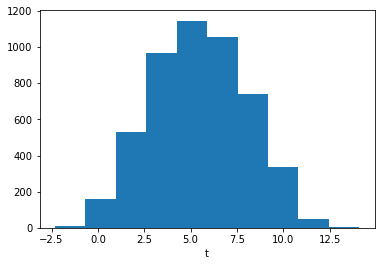

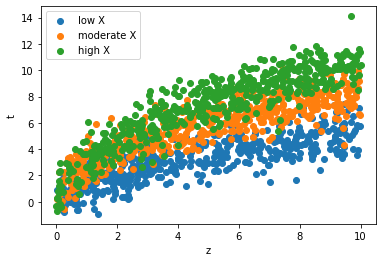

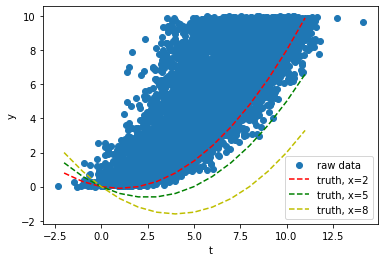

In [21]:
n = 5000

# Initialize exogenous variables; normal errors, uniformly distributed covariates and instruments
e = np.random.normal(size=(n,))
x = np.random.uniform(low=0.0, high=10.0, size=(n,))
z = np.random.uniform(low=0.0, high=10.0, size=(n,))

# Initialize treatment variable
t = np.sqrt((x+2) * z) + e

# Show the marginal distribution of t
plt.hist(t)
plt.xlabel("t")
plt.show()

plt.scatter(z[x < 1], t[x < 1], label='low X')
plt.scatter(z[(x > 4.5) * (x < 5.5)], t[(x > 4.5) * (x < 5.5)], label='moderate X')
plt.scatter(z[x > 9], t[x > 9], label='high X')
plt.legend()
plt.xlabel("z")
plt.ylabel("t")
plt.show()

# Outcome equation 
y = t*t / 10 - x*t / 10 + e

# The endogeneity problem is clear, the latent error enters both treatment and outcome equally
plt.scatter(t,z, label ='raw data')
tticks = np.arange(-2,12)
yticks2 = tticks*tticks/10 - 0.2 * tticks
yticks5 = tticks*tticks/10 - 0.5 * tticks
yticks8 = tticks*tticks/10 - 0.8 * tticks
plt.plot(tticks,yticks2, 'r--', label = 'truth, x=2')
plt.plot(tticks,yticks5, 'g--', label = 'truth, x=5')
plt.plot(tticks,yticks8, 'y--', label = 'truth, x=8')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [23]:
import pandas as pd
from ylearn.estimator_model.utils import convert2tensor
z, w, x, y = convert2tensor(z, x, t, y)
z = z.squeeze().to(torch.float32)
w = w.squeeze().to(torch.float32)
x = x.squeeze().to(torch.float32)
y = y.squeeze().to(torch.float32)

data_dict = {
    'z': z,
    'w': x,
    'x': t,
    'y': y
}
data = pd.DataFrame(data_dict)

In [24]:
iv = DeepIV(num_gaussian=10)
iv.fit(
    data=data,
    outcome='y',
    treatment='x',
    instrument='z',
    adjustment='w',
    sample_n=2,
    lr=0.5,
    epoch=1,
    device='cpu',
    batch_size=5000
)

Finished 1/1 epochs | current loss -4.830622416434856
Finished 1/1 epochs | current loss 3.792553104354691e+32


In [25]:
iv.estimate()

tensor([nan], grad_fn=<MeanBackward1>)